# **Predicting Tarmac Delays**

This notebook will focus purely on exploratory data analysis and modeling. The following data was scraped and merged from two different sources: *Bureau of Transportation Statistics* and *WeatherUnderground*. For more information on how I scraped this data, please refer to the **Data Collection (Web Scraping).ipynb** notebook.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV, lars_path
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from chart_studio.plotly import plot, iplot as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

import xgboost as xgb
from xgboost import plot_importance

import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
df = pd.read_pickle('Data/FINAL3')

In [3]:
df.head()

,Origin,Date,Num Gates,Carrier Code,Tail Number,Cert_Date,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),...,Max_Humid,Avg_Humidity,Min_Humid,Max_Wind,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Precipitation
0,SFO,01/01/2018,115,WN,N8651A,10/16/2014,MDW,05:15,05:15,0.0,...,93,82.3,67,5,1.7,0,30.2,30.2,30.1,0.00
1,SFO,04/08/2018,115,WN,N8651A,10/16/2014,PDX,20:30,21:17,47.0,...,83,64.6,45,26,12.0,0,30.2,30.2,30.1,0.10
2,SFO,06/01/2018,115,WN,N8651A,10/16/2014,PDX,06:20,06:18,-2.0,...,80,61.7,39,26,11.6,0,30.1,30.0,30.0,0.00
3,SFO,06/02/2018,115,WN,N8651A,10/16/2014,PHX,11:25,11:23,-2.0,...,69,58.3,33,23,10.3,0,30.0,29.9,29.9,0.00
4,SFO,06/18/2018,115,WN,N8651A,10/16/2014,MDW,09:25,09:24,-1.0,...,77,67.6,55,24,11.4,0,30.1,30.0,30.0,0.00


In [4]:
df.shape

(186526, 33)

In [5]:
df.columns.tolist()

['Origin',
 'Date',
 'Num Gates',
 'Carrier Code',
 'Tail Number',
 'Cert_Date',
 'Destination Airport',
 'Scheduled departure time',
 'Actual departure time',
 'Departure delay (Minutes)',
 'Wheels-off time',
 'Taxi-Out time (Minutes)',
 'Delay Carrier (Minutes)',
 'Delay Weather (Minutes)',
 'Delay National Aviation System (Minutes)',
 'Delay Security (Minutes)',
 'Delay Late Aircraft Arrival (Minutes)',
 'Max_Temp',
 'Avg_Temp',
 'Min_Temp',
 'Max_Dew',
 'Avg_DewPoint',
 'Min_Dew',
 'Max_Humid',
 'Avg_Humidity',
 'Min_Humid',
 'Max_Wind',
 'Avg_Wind',
 'Min_Wind',
 'Max_Pressure',
 'Avg_Pressure',
 'Min_Pressure',
 'Precipitation']

In [6]:
df.dtypes

Origin                                       object
Date                                         object
Num Gates                                     int64
Carrier Code                                 object
Tail Number                                  object
Cert_Date                                    object
Destination Airport                          object
Scheduled departure time                     object
Actual departure time                        object
Departure delay (Minutes)                   float64
Wheels-off time                              object
Taxi-Out time (Minutes)                     float64
Delay Carrier (Minutes)                     float64
Delay Weather (Minutes)                     float64
Delay National Aviation System (Minutes)    float64
Delay Security (Minutes)                    float64
Delay Late Aircraft Arrival (Minutes)       float64
Max_Temp                                     object
Avg_Temp                                     object
Min_Temp    

## **Column Definitions and Data Pre-processing**

For the sake of clarity, lets define what all these columns actually mean to get a better understanding of the date we are looking at.


**Origin** - The origin of the airport. In this case, Origin should have unique values of each airport that we chose to include in this data.  
  
**Date** - The date that this airport took off from the origin airport. 
    
**Carrier Code** - Airline code denoting which airline controls this flight  
  
**Tail Number** - Unique flight ID
  
**Destination Airport** - destination airport of this flight 
  
**Scheduled depature time** - scheduled departure time 
     
**Departure delay (Minutes)** - Delay in aircraft departure. A negative value indicates the number of minutes that an aircraft departed before its scheduled departure time.  

**Wheels-off time** - Departure time + Taxi-Out time : this is the time that the plane actually leaves the ground (takeoff)
   
**Taxi-Out time (Minutes)** - Time from leaving depature gate to actually leaving the ground  

**Delay Carrier (Minutes)** - Any aircraft delay due to delays with that specific Airline carrier  

**Delay Weather (Minutes)** - Delays resulting from weather conditions  
  
**Delay National Aviation System (Minutes)** - General nationwide delay in aviation operations  

**Delay Security (Minutes)** - Delay due to airport security issues  
   
**Delay Late Aircraft Arrival (Minutes)** - Delay due to an aircraft arriving late  

**Num_Gates** - Number of gates in that specific airport  

**Cert_Date** - The date that this specific aircraft was first certified to fly (this is a proxy for an aircraft's age)    

 


In [7]:
def get_daypart(time):
    start_times = ["05:00", "08:00", "12:00", "17:00", "21:00"]
    end_times = ["08:00", "12:00", "17:00", "21:00", "05:00"]
    day_part_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]
    
    for index, hour in enumerate(start_times):        
        first_time = datetime.datetime.strptime(hour,"%H:%M")
        second_time = datetime.datetime.strptime(end_times[index],"%H:%M")
        
        if time.time() >= first_time.time() and time.time() < second_time.time():
            return day_part_list[index]      
        elif index == 4:
            return day_part_list[index]

def get_day(date):    
    num = date.to_pydatetime().weekday()
    day_dict = {0 : 'Mon', 1 : 'Tues', 2 : 'Wed', 3 : 'Thurs', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}
    return day_dict[num]

def get_month(date): 
    month_dict = {1 : 'Jan', 4 : 'Apr', 6 : 'Jun', 10 : 'Oct'}
    num = date.to_pydatetime().month
    return month_dict[num]

In [8]:
# Data Cleaning : This cell focuses on getting all the columns in the dataframe into the proper data types

df['Actual departure time'] = df['Actual departure time' ].str.replace('24', '00')

df = df[df['Cert_Date'] != 'Aircraft Description']
df = df[df['Cert_Date'] != 'None']

df['Scheduled departure time'] = df['Date'] + ' ' + df['Scheduled departure time'] 
df['Actual departure time'] = df['Date'] + ' ' + df['Actual departure time']

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format="%m/%d/%Y %H:%M")
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format="%m/%d/%Y %H:%M") 

df['Cert_Date'] = pd.to_datetime(df['Cert_Date'], format='%m/%d/%Y')

df['Age'] = (df['Date'] - df['Cert_Date']).dt.days

df['DayOfWeek'] = df['Date'].apply(lambda row: get_day(row))
df['Month'] = df['Date'].apply(lambda row: get_month(row))

df['DayPart'] = df['Actual departure time'].apply(lambda row: get_daypart(row))

### **Handling Outliers**

Let's take a look at a boxplot of our target variable (Taxi-Out time) to identify any outliers.

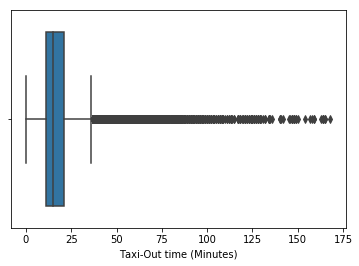

In [9]:
ax = sns.boxplot(x=df["Taxi-Out time (Minutes)"])
plt.show()

In [10]:
Q1 = df["Taxi-Out time (Minutes)"].quantile(0.25)
Q3 = df["Taxi-Out time (Minutes)"].quantile(0.75)
IQR = Q3 - Q1

bound = Q3 + 1.5 * IQR
print(f'The upper bound time limit for taxi time is : {bound}')

The upper bound time limit for taxi time is : 36.0


### Months

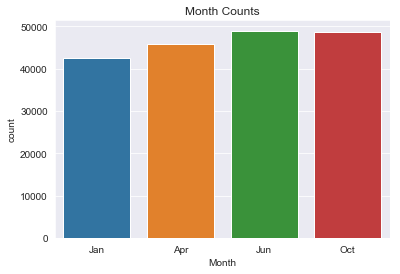

In [11]:
sns.set_style('darkgrid')
ax = sns.countplot(x="Month", data=df)
ax.set_title('Month Counts');

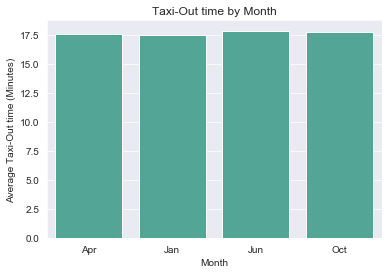

In [12]:
month_grouped = df.groupby(['Month'])['Taxi-Out time (Minutes)'].mean()

month_grouped = month_grouped.reset_index()

ax = sns.barplot(x='Month', y='Taxi-Out time (Minutes)', data=month_grouped, color='#45B39D');

ax.set_title('Taxi-Out time by Month');
ax.set_ylabel('Average Taxi-Out time (Minutes)');

### Days

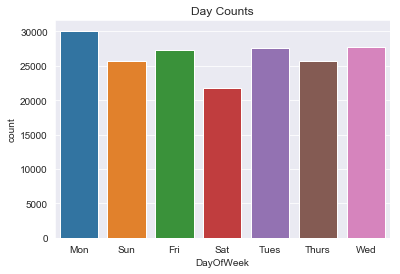

In [13]:
ax = sns.countplot(x="DayOfWeek", data=df)
ax.set_title('Day Counts');

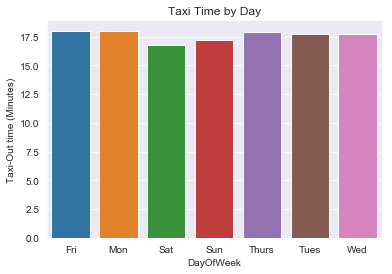

In [14]:
week_grouped = df.groupby(['DayOfWeek'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayOfWeek', y='Taxi-Out time (Minutes)', data=week_grouped);

ax.set_title('Taxi Time by Day');

### Time of Day

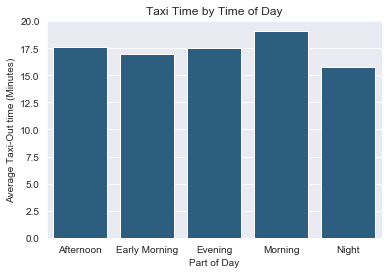

In [15]:
week_grouped = df.groupby(['DayPart'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayPart', y='Taxi-Out time (Minutes)', data=week_grouped, color='#1F618D')

ax.set_title('Taxi Time by Time of Day')
ax.set_xlabel('Part of Day')
ax.set_ylabel('Average Taxi-Out time (Minutes)');

### Airlines

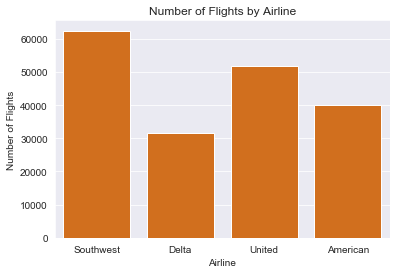

In [16]:
line_names = ['Southwest', 'Delta', 'United', 'American']
df['Carrier Code'].value_counts()
ax = sns.countplot(x="Carrier Code", data=df, color='#EF6C00')
ax.set_title('Number of Flights by Airline');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Number of Flights');

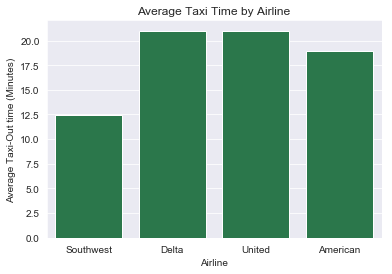

In [17]:
airline_grouped = df.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index()

orderl = ['WN', 'DL', 'UA', 'AA']
ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', order=orderl, data=airline_grouped, color='#1E8449');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_title('Average Taxi Time by Airline');

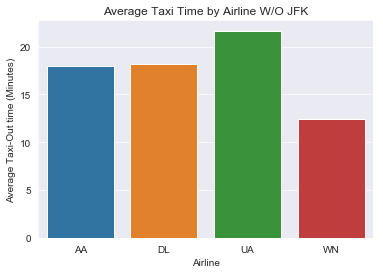

In [18]:
df2 = df.copy()
df2 = df2[(df2['Origin'] != 'JFK') & (df2['Origin'] != 'IAH') & (df2['Origin'] != 'HNL')]

airline_grouped = df2.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index() 

ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', data=airline_grouped);
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airline')
ax.set_title('Average Taxi Time by Airline W/O JFK');

Notice that even if we remove the 3 airports that Southwest (WN) doesn't serve (JFK, IAH, HNL), Southwest still has noticeably shorter taxi times than the other 3 airlines.

### Airports

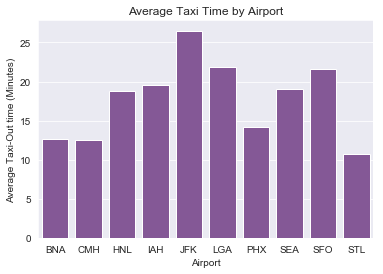

In [19]:
airport_grouped = df.groupby(['Origin'])['Taxi-Out time (Minutes)'].mean()
airport_grouped = airport_grouped.reset_index()
ax = sns.barplot(x='Origin', y='Taxi-Out time (Minutes)', data=airport_grouped, color='#884EA0')
ax.set_title('Average Taxi Time by Airport');
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airport');

Grouping by airport produces results as expected. Busier airports like JFK, LGA, and SFO tend to have more traffic and naturally higher taxi-out times.

In [20]:
df.columns

Index(['Origin', 'Date', 'Num Gates', 'Carrier Code', 'Tail Number',
       'Cert_Date', 'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Departure delay (Minutes)', 'Wheels-off time',
       'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Dew', 'Avg_DewPoint',
       'Min_Dew', 'Max_Humid', 'Avg_Humidity', 'Min_Humid', 'Max_Wind',
       'Avg_Wind', 'Min_Wind', 'Max_Pressure', 'Avg_Pressure', 'Min_Pressure',
       'Precipitation', 'Age', 'DayOfWeek', 'Month', 'DayPart'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



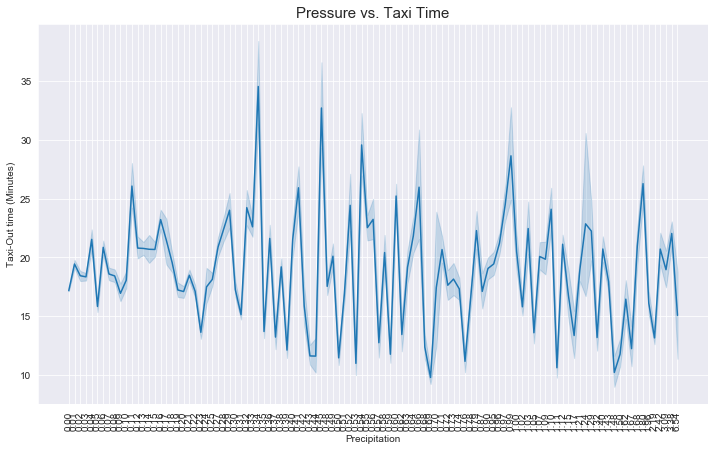

In [21]:
fig, ax = plt.subplots(figsize=(12,7)) 
sns.lineplot(x='Precipitation', y='Taxi-Out time (Minutes)', data=df)
plt.xticks(rotation=90);
plt.title("Pressure vs. Taxi Time", size=15);
plt.savefig('pressure_plot', bbox_inches ='tight', dpi = 400)

## Air Pressure

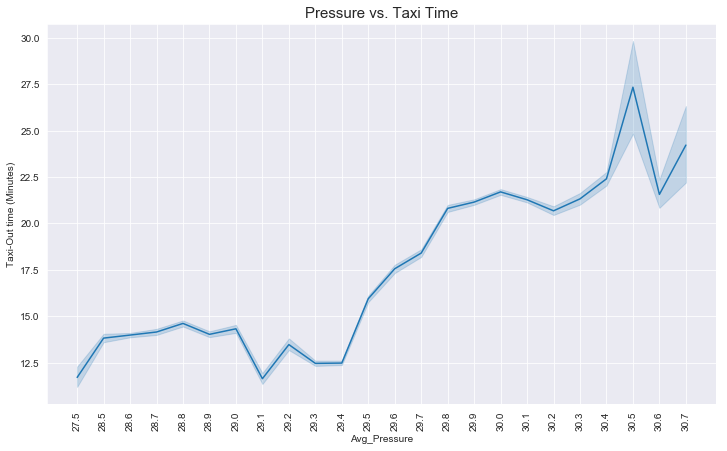

In [22]:
fig, ax = plt.subplots(figsize=(12,7)) 
sns.lineplot(x='Avg_Pressure', y='Taxi-Out time (Minutes)', data=df)
plt.xticks(rotation=90);
plt.title("Pressure vs. Taxi Time", size=15);
plt.savefig('pressure_plot', bbox_inches ='tight', dpi = 400)

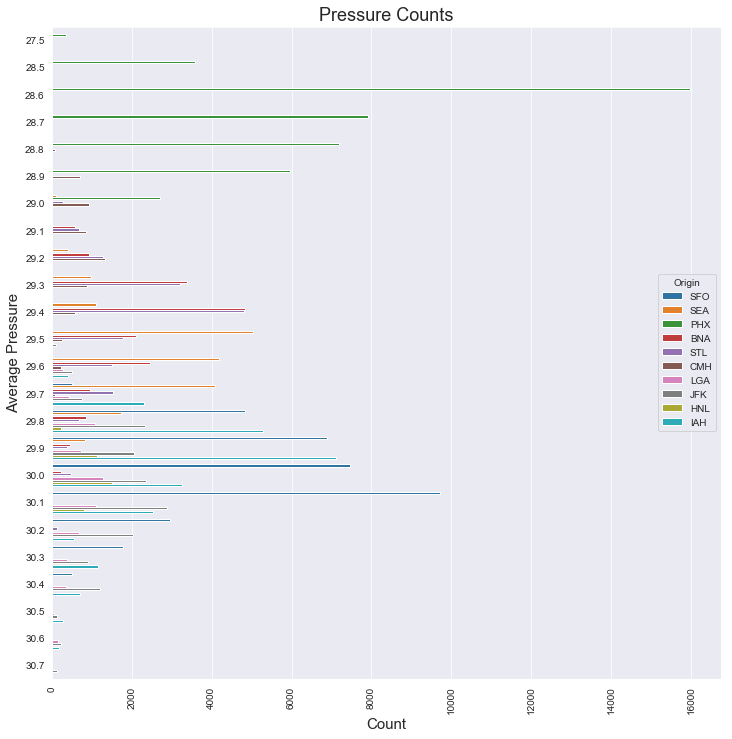

In [23]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.countplot(y="Avg_Pressure", data=df, hue='Origin')
#sns.countplot(y="Avg_Pressure", data=df)
ax.set_title('Pressure Counts', size=18);
ax.set_xlabel('Count', size=15)
ax.set_ylabel('Average Pressure', size=15)
plt.xticks(rotation=90);
plt.savefig('pressure_plot', bbox_inches ='tight', dpi = 400);

While an initial glance at air pressure indicates that taxi time tends to increase as pressure increases, it is actually a bit misleading. Further investigation into average air pressure readings for all the airports reveals that busy airports such as SFO tend to have high air pressure just due to location. As a result, pressure itself almost acts as a proxy for airports and research shows that pressure doesn't really have a direct effect on taxi time.


### More Data Cleaning

In [24]:
df.head()

,Origin,Date,Num Gates,Carrier Code,Tail Number,Cert_Date,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),...,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Precipitation,Age,DayOfWeek,Month,DayPart
0,SFO,2018-01-01,115,WN,N8651A,2014-10-16,MDW,2018-01-01 05:15:00,2018-01-01 05:15:00,0.0,...,1.7,0,30.2,30.2,30.1,0.00,1173.0,Mon,Jan,Early Morning
1,SFO,2018-04-08,115,WN,N8651A,2014-10-16,PDX,2018-04-08 20:30:00,2018-04-08 21:17:00,47.0,...,12.0,0,30.2,30.2,30.1,0.10,1270.0,Sun,Apr,Night
2,SFO,2018-06-01,115,WN,N8651A,2014-10-16,PDX,2018-06-01 06:20:00,2018-06-01 06:18:00,-2.0,...,11.6,0,30.1,30.0,30.0,0.00,1324.0,Fri,Jun,Early Morning
3,SFO,2018-06-02,115,WN,N8651A,2014-10-16,PHX,2018-06-02 11:25:00,2018-06-02 11:23:00,-2.0,...,10.3,0,30.0,29.9,29.9,0.00,1325.0,Sat,Jun,Morning
4,SFO,2018-06-18,115,WN,N8651A,2014-10-16,MDW,2018-06-18 09:25:00,2018-06-18 09:00:00,-1.0,...,11.4,0,30.1,30.0,30.0,0.00,1341.0,Mon,Jun,Morning


In [25]:
df.columns

Index(['Origin', 'Date', 'Num Gates', 'Carrier Code', 'Tail Number',
       'Cert_Date', 'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Departure delay (Minutes)', 'Wheels-off time',
       'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Dew', 'Avg_DewPoint',
       'Min_Dew', 'Max_Humid', 'Avg_Humidity', 'Min_Humid', 'Max_Wind',
       'Avg_Wind', 'Min_Wind', 'Max_Pressure', 'Avg_Pressure', 'Min_Pressure',
       'Precipitation', 'Age', 'DayOfWeek', 'Month', 'DayPart'],
      dtype='object')

In [26]:
df = pd.get_dummies(data=df, columns=['Origin', 'Carrier Code', 'DayPart' , 'DayOfWeek', 'Month'], drop_first=True)

In [27]:
numeric_cols = ['Origin_CMH', 'Origin_HNL','Origin_IAH', 'Origin_JFK', 'Origin_LGA',
                'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL', 'Carrier Code_DL', 'Carrier Code_UA','Carrier Code_WN', 
                'DayPart_Early Morning', 'DayPart_Morning','DayPart_Evening', 'DayPart_Night', 'Departure delay (Minutes)', 'Taxi-Out time (Minutes)',
                'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
                'Avg_Temp', 'Avg_Wind', 'Avg_Humidity', 'Avg_Pressure', 'Precipitation']

In [28]:
only_num2 = df[numeric_cols].copy()
only_num2 = only_num2.apply(pd.to_numeric)
only_num2 = only_num2.dropna(how='any')
only_num2 = only_num2[only_num2['Departure delay (Minutes)'] <= 60] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] >= 5] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] <= 30]

only_num2 = only_num2[only_num2['Delay Weather (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay Carrier (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay National Aviation System (Minutes)'] < 30]
#only_num2 = only_num2[only_num2['Avg_Pressure'] <= 30.4]

only_num2['Departure delay (Minutes)'] = only_num2['Departure delay (Minutes)'].astype(int)
only_num2['Taxi-Out time (Minutes)'] = only_num2['Taxi-Out time (Minutes)'].astype(int)                  
only_num2['Delay Weather (Minutes)'] = only_num2['Delay Weather (Minutes)'].astype(int)                     
only_num2['Delay National Aviation System (Minutes)'] = only_num2['Delay National Aviation System (Minutes)'].astype(int)    
only_num2['Delay Carrier (Minutes)'] = only_num2['Delay Carrier (Minutes)'].astype(int)

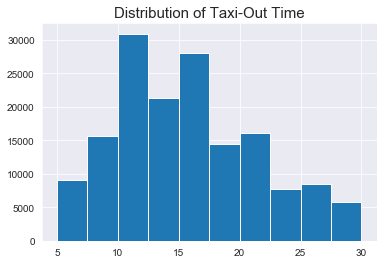

In [29]:
X2 = only_num2.copy()
X2 = X2.drop(columns=['Taxi-Out time (Minutes)']) 
y2 = only_num2['Taxi-Out time (Minutes)']
y2.hist(); 
plt.title('Distribution of Taxi-Out Time', size=15);

Notice that the target variable doesn't exactly follow a perfect normal distribution. While it may not be necessary for the target variable to have a perfectly normal distribution, using a natural logged version of the target resulted in a better model.

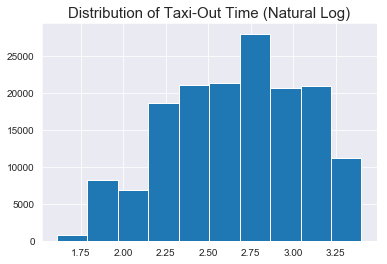

In [30]:
y2 = np.log(y2)
y2.hist();
plt.title('Distribution of Taxi-Out Time (Natural Log)', size=15);

## Train-Test-Split

In [63]:
X, X_test, y, y_test = train_test_split(X2, y2, test_size=.2, random_state=21)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [64]:
X_train.shape

(94527, 25)

In [65]:
X_val.shape

(31509, 25)

In [66]:
X.shape

(126036, 25)

## Statsmodels Linear Regression

In [67]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
model = sm.OLS(y_train, sm.add_constant(X_train_scaled))

fit2 = model.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Taxi-Out time (Minutes)   R-squared:                       0.449
Model:                                 OLS   Adj. R-squared:                  0.448
Method:                      Least Squares   F-statistic:                     3076.
Date:                     Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                             14:29:44   Log-Likelihood:                -16939.
No. Observations:                    94527   AIC:                         3.393e+04
Df Residuals:                        94501   BIC:                         3.418e+04
Df Model:                               25                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6678      0.001   2833.244      0.000       2.666       2.670
x1            -0.0086      0.001     -7.517      0.000      -0.011      -0.006
x2             0.0420      0.001     31.838      0.000       0.039       0.045
x3             0.0572      0.002     26.941      0.000       0.053       0.061
x4             0.0800      0.002     46.751      0.000       0.077       0.083
x5             0.0526      0.001     40.490      0.000       0.050       0.055
x6             0.0444      0.003     15.340      0.000       0.039       0.050
x7             0.0759      0.001     54.444      0.000       0.073       0.079
x8             0.1105      0.002     48.455      0.000       0.106       0.115
x9            -0.0373      0.001    -28.726      0.000      -0.040      -0.035
x10           -0.0333      0.001    -27.231      0.000      -0.036      -0.031
x11           -0.0184      0.001    -12.397      0.000      -0.021      -0.016
x12           -0.1559      0.001   -115.762      0.000      -0.159      -0.153
x13            0.0138      0.001     12.391      0.000       0.012       0.016
x14            0.0462      0.001     40.648      0.000       0.044       0.048
x15           -0.0075      0.001     -6.739      0.000      -0.010      -0.005
x16           -0.0141      0.001    -13.407      0.000      -0.016      -0.012
x17           -0.0055      0.001     -4.969      0.000      -0.008      -0.003
x18            0.0057      0.001      6.012      0.000       0.004       0.008
x19            0.0366      0.001     38.222      0.000       0.035       0.038
x20            0.0082      0.001      7.724      0.000       0.006       0.010
x21           -0.0115      0.001     -7.860      0.000      -0.014      -0.009
x22            0.0118      0.001     10.377      0.000       0.010       0.014
x23            0.0194      0.002     12.023      0.000       0.016       0.023
x24            0.0193      0.004      5.054      0.000       0.012       0.027
x25            0.0007      0.001      0.704      0.481      -0.001       0.003
==============================================================================
Omnibus:                      372.161   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.951
Skew:                           0.151   Prob(JB):                     3.81e-82
Kurtosis:                       2.933   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



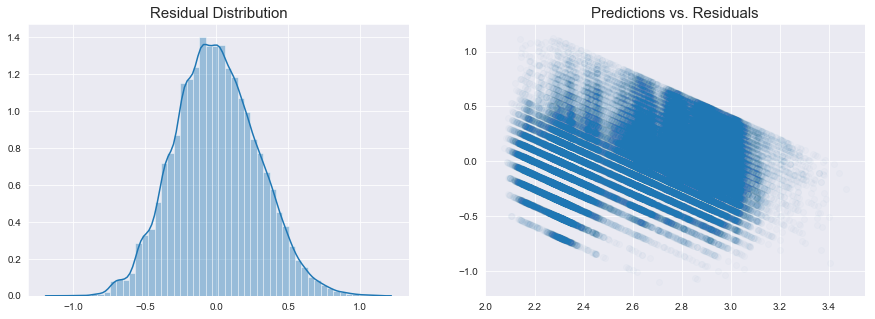

In [68]:
fig = plt.figure(1, figsize=(15,5))
axis = fig.add_subplot(1,2,1)
ax1 = sns.distplot(fit2.resid)
plt.title('Residual Distribution', size=15);
axis = fig.add_subplot(1,2,2)
plt.scatter(fit2.predict(), fit2.resid, alpha = 0.02);
plt.title('Predictions vs. Residuals', size=15);


 ## Proving the Assumptions of Linear Regression

Looking at the plots above reveals that distribution of residuals is normal. However there is heteroscedasity present which is reasonable given that the model is trying to predict taxi time. Taxi time is also affected by other factors not included in the data such as how fast a pilot drives. But longer delays tend to be tied to delays in the National Aviation System which is included as a feature. It is likely that this feature is an important part of why the model is able to predict longer delays better than shorter ones.

## Scikit-Learn Regression and Validation

In [69]:
lm = LinearRegression() 

lm.fit(X_train, y_train)

print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

#Need to scale features for Ridge Regression
scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_train_scaled, y_train)

print(' ')
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')


Linear Regression train R^2: 0.449
Linear Regression val R^2: 0.449
 
Ridge Regression train R^2: 0.449
Ridge Regression val R^2: 0.449


In [70]:
coef_list = list(zip(X_train.columns, np.exp(lm.coef_)))
coef_list = sorted(coef_list, key=lambda x: x[1])
coef_list = coef_list[::-1]

In [71]:
names = [x[0] for x in coef_list]
weights = [y[1] for y in coef_list]

In [72]:
X_train.columns

Index(['Origin_CMH', 'Origin_HNL', 'Origin_IAH', 'Origin_JFK', 'Origin_LGA',
       'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL',
       'Carrier Code_DL', 'Carrier Code_UA', 'Carrier Code_WN',
       'DayPart_Early Morning', 'DayPart_Morning', 'DayPart_Evening',
       'DayPart_Night', 'Departure delay (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
       'Avg_Temp', 'Avg_Wind', 'Avg_Humidity', 'Avg_Pressure',
       'Precipitation'],
      dtype='object')

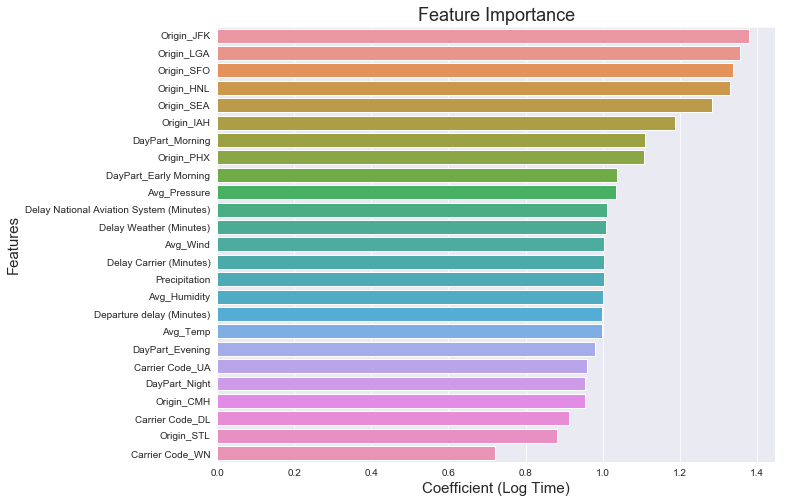

In [73]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=weights, y=names)
#ax.set(xticks=xtick_list)
ax.set_title('Feature Importance', size=18)
ax.set_xlabel('Coefficient (Log Time)', size=15)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

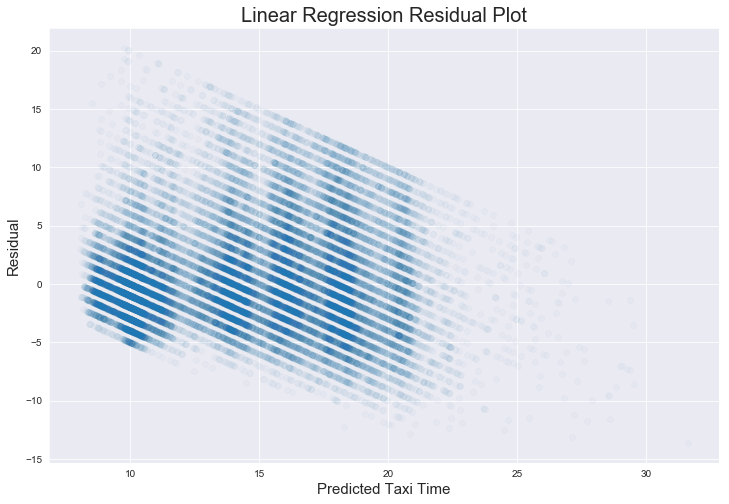

In [74]:
y_val_pred= lm.predict(X_val)

plt.figure(figsize=(12,8))
plt.scatter(np.exp(y_val_pred), np.exp(y_val) - np.exp(y_val_pred), alpha = 0.025)
plt.title('Linear Regression Residual Plot', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.ylabel('Residual', size = 15);
plt.savefig('residual_plot', bbox_inches ='tight', dpi = 400)
#plt.scatter(np.exp(y_test_pred), np.exp(y_test), alpha = 0.1)

In [75]:
y_val_pred= lm.predict(X_val)
y_reg_val_pred = lm_reg.predict(X_val_scaled)

mae_linear = np.mean(np.abs(np.exp(y_val) - np.exp(y_val_pred)))
print("Linear MAE on Validation:", mae_linear)

y_test_pred= lm.predict(X_test)
mae_linear_test = np.mean(np.abs(np.exp(y_test) - np.exp(y_test_pred)))
print("Linear MAE on Test:", mae_linear_test)

mae_justridge = np.mean(np.abs(np.exp(y_reg_val_pred) - np.exp(y_val))) 

y_reg_test_pred= lm_reg.predict(X_test_scaled)
mae_justridge_test = np.mean(np.abs(np.exp(y_reg_test_pred) - np.exp(y_test))) 

print("Ridge MAE on Validation:", mae_justridge)
print("Ridge MAE on Test:", mae_justridge_test)

Linear MAE on Validation: 3.5252879449958052
Linear MAE on Test: 3.568483622338276
Ridge MAE on Validation: 3.525287728369275
Ridge MAE on Test: 3.568483083916306


## RidgeCV

In [76]:
kf = KFold(n_splits=5, shuffle=True, random_state = 89)

X_scaled = scaler.fit_transform(X.values)

print("R^2 Linear:",np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print("R^2 Ridge:",np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2')))


R^2 Linear: 0.44848851064355555
R^2 Ridge: 0.4484885232936566


In [77]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('RidgeCV alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'RidgeCV val R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')


RidgeCV alpha: 19.791668678535572
RidgeCV train R^2: 0.449
RidgeCV val R^2: 0.449


In [78]:
ridge_cv_pred = ridge_model.predict(X_val_scaled)
mae_ridgecv_val = np.mean(np.abs(np.exp(ridge_cv_pred) - np.exp(y_val))) 

ridge_cv_pred = ridge_model.predict(X_test_scaled)
mae_ridgecv_test = np.mean(np.abs(np.exp(ridge_cv_pred) - np.exp(y_test))) 

print("Ridge MAE on Validation:", mae_ridgecv_test)
print("Ridge MAE on Test:", mae_justridge_test)

Ridge MAE on Validation: 3.5684732669545927
Ridge MAE on Test: 3.568483083916306


## LassoCV and Feature Selection

In [79]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train.values, y_train.values, method='lasso')

Computing regularization path using the LARS ...


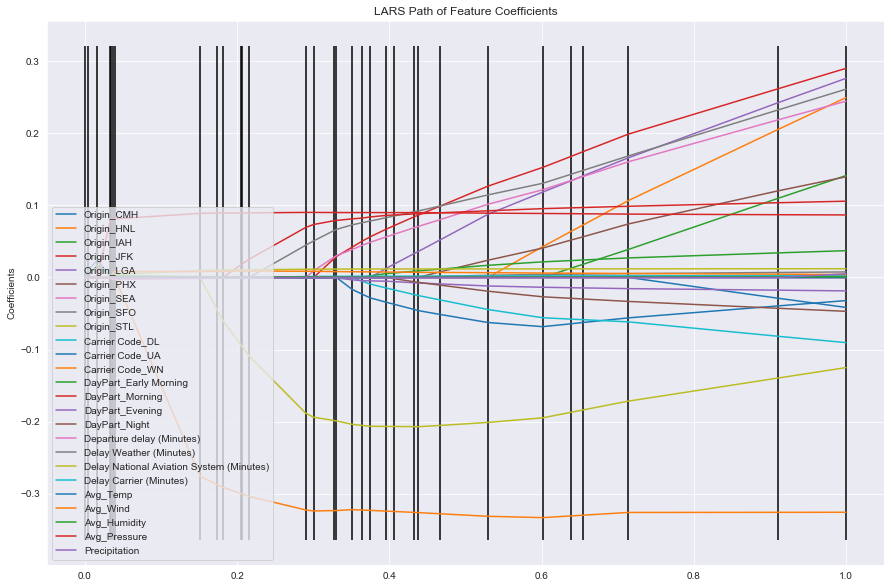

In [80]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

col_names = X_train.columns

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax)
plt.ylabel('Coefficients')
plt.title('LARS Path of Feature Coefficients')
plt.axis('tight')
plt.legend(col_names, loc = 'lower left')
plt.show()

In [81]:
alphavec = 10**np.linspace(-3,3,200)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')


y_lcv_val_pred = lasso_model.predict(X_val_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_val_pred) - np.exp(y_val))) 

print('MAE for LassoCV:', mae_lcv)

LassoCV alpha: 0.001
LassoCV train R^2: 0.448
LassoCV val R^2: 0.449
MAE for LassoCV: 3.52582099157588


In [82]:
y_lcv_test_pred = lasso_model.predict(X_test_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_test_pred) - np.exp(y_test))) 

print('MAE for LassoCV:', mae_lcv)

MAE for LassoCV: 3.5692235162560557


In [83]:
coef_list = list(zip(X_train.columns, np.exp(lasso_model.coef_)))
coef_list = sorted(coef_list, key=lambda x: x[1])
coef_list

[('Carrier Code_WN', 0.856462106271055),
 ('Origin_STL', 0.9600241285723974),
 ('Carrier Code_DL', 0.970771293553461),
 ('DayPart_Night', 0.9869101682395167),
 ('Carrier Code_UA', 0.9879426466549802),
 ('Origin_CMH', 0.9898474830479296),
 ('Avg_Temp', 0.9908742018163985),
 ('DayPart_Evening', 0.9928333336558431),
 ('Departure delay (Minutes)', 0.9962951829215355),
 ('Precipitation', 1.0001416895147688),
 ('Delay Weather (Minutes)', 1.0045122320447075),
 ('Delay Carrier (Minutes)', 1.0062954924018792),
 ('Avg_Wind', 1.011798965774592),
 ('DayPart_Early Morning', 1.012763478163422),
 ('Avg_Humidity', 1.0166466962559029),
 ('Avg_Pressure', 1.019842885062662),
 ('Origin_PHX', 1.034485850684311),
 ('Delay National Aviation System (Minutes)', 1.0362983283945435),
 ('Origin_HNL', 1.0378891599464193),
 ('DayPart_Morning', 1.046168928059308),
 ('Origin_IAH', 1.0488675002939816),
 ('Origin_LGA', 1.0492325007466594),
 ('Origin_SEA', 1.071852639180689),
 ('Origin_JFK', 1.0776951899191742),
 ('Orig

# RidgeCV for Polynomial Features

In [84]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)

X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_val_poly_scaled = scaler.fit_transform(X_val_poly)


alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_poly_scaled, y_train)

print('RidgeCV alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_poly_scaled, y_train):.3f}')
print(f'RidgeCV val R^2: {ridge_model.score(X_val_poly_scaled, y_val):.3f}')

y_rcv_val_pred = ridge_model.predict(X_val_poly_scaled)

mae_rcv = np.mean(np.abs(np.exp(y_rcv_val_pred) - np.exp(y_val))) 

print('MAE Poly for RidgeCV:', mae_rcv)

RidgeCV alpha: 0.01
RidgeCV train R^2: 0.507
RidgeCV val R^2: 0.504
MAE Poly for RidgeCV: 3.3488999775485313


# LassoCV for Polynomial Features

In [85]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_poly_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_poly_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_poly_scaled, y_val):.3f}')

y_lcv_val_pred = lasso_model.predict(X_val_poly_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_val_pred) - np.exp(y_val))) 

print('MAE Poly for LassoCV:', mae_lcv)

LassoCV alpha: 0.01
LassoCV train R^2: 0.470
LassoCV val R^2: 0.470
MAE Poly for LassoCV: 3.476850717795916


## ElasticNetCV for Polynomial Features

In [86]:
alphavec = 10**np.linspace(-2,2,200)

elastic_model = ElasticNetCV(l1_ratio=0.01, alphas = alphavec, cv=kf)

elastic_model.fit(X_train_poly_scaled, y_train)

print('ElasticNetCV alpha:', elastic_model.alpha_)

print(f'ElasticNetCV train R^2: {elastic_model.score(X_train_poly_scaled, y_train):.3f}')
print(f'ElasticNetCV val R^2: {elastic_model.score(X_val_poly_scaled, y_val):.3f}')

y_ecv_val_pred = elastic_model.predict(X_val_poly_scaled)

mae_ecv = np.mean(np.abs(np.exp(y_ecv_val_pred) - np.exp(y_val))) 

print('MAE Poly for ElasticNetCV:', mae_ecv)

ElasticNetCV alpha: 0.01
ElasticNetCV train R^2: 0.504
ElasticNetCV val R^2: 0.502
MAE Poly for ElasticNetCV: 3.3555194381879336


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.56502002615525, tolerance: 1.4364477319631814



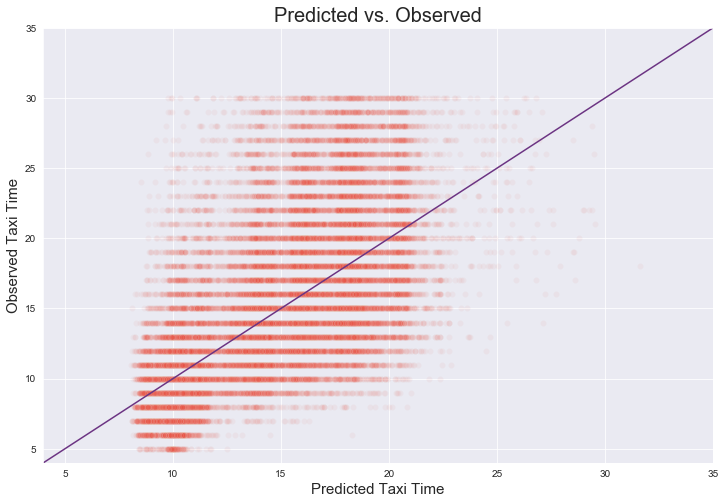

In [87]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(np.exp(y_val_pred), np.exp(y_val), alpha = 0.05, color='#E74C3C')
ax = sns.lineplot(np.linspace(4,40,100), np.linspace(4,40,100), color='#6C3483')
plt.title('Predicted vs. Observed', size=20)
plt.xlabel('Predicted Taxi Time', size=15)
plt.ylabel('Observed Taxi Time', size=15)
plt.ylim([4,35]);
plt.xlim([4,35]);

plt.savefig('comparison', bbox_inches ='tight', dpi = 400)


## XGBoost Regression

In [88]:
eval_set = [(X_val, y_val)]

In [89]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, #arbitrary large number
                       max_depth=7,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.6
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go

xgb_reg = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mae',
                    early_stopping_rounds=20,
                    verbose=100 #gives output log as below
                   )

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-mae:1.95118	validation_1-mae:1.94937
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[100]	validation_0-mae:0.207635	validation_1-mae:0.213814
[200]	validation_0-mae:0.200794	validation_1-mae:0.21184
[300]	validation_0-mae:0.196137	validation_1-mae:0.211299
Stopping. Best iteration:
[359]	validation_0-mae:0.193769	validation_1-mae:0.211066



In [90]:
xgb_pred = xgb_reg.predict(X_test)

xgb_mae = np.mean(np.abs(np.exp(xgb_pred) - np.exp(y_test)))
xgb_mae

3.2724909153941018